In [1]:
import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import roc_curve, confusion_matrix, auc,plot_confusion_matrix,precision_recall_curve, accuracy_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier

### Part 1 ‑ Exploratory data analysis on User Login Data

In [5]:
login=pd.read_json('logins.json')
login=login.sort_values(by='login_time',ascending=True)
login=login.reset_index()
login.drop('index',axis=1,inplace=True)

In [6]:
login

,login_time
0,1970-01-01 20:12:16
1,1970-01-01 20:13:18
2,1970-01-01 20:16:10
3,1970-01-01 20:16:36
4,1970-01-01 20:16:37
...,...
93137,1970-04-13 18:48:52
93138,1970-04-13 18:50:19
93139,1970-04-13 18:54:02
93140,1970-04-13 18:54:23


In [7]:
login_15m=login.groupby(pd.Grouper(freq='15T',key='login_time'))['login_time'].count().fillna(0)
login_15m

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
                      ..
1970-04-13 17:45:00    5
1970-04-13 18:00:00    5
1970-04-13 18:15:00    2
1970-04-13 18:30:00    7
1970-04-13 18:45:00    6
Freq: 15T, Name: login_time, Length: 9788, dtype: int64

/Users/ruoqigao/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


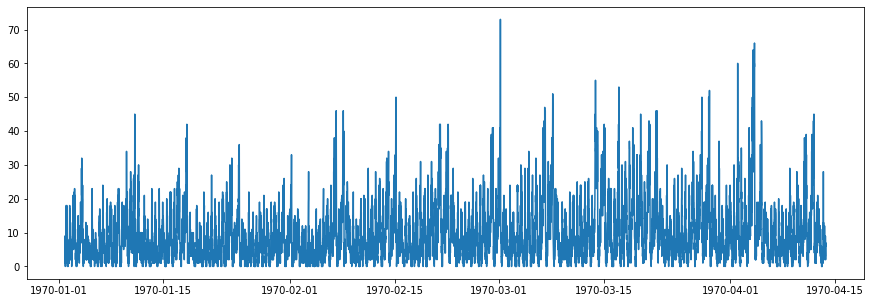

In [8]:
plt.figure(figsize=[15,5])
sns.lineplot(data=login_15m)

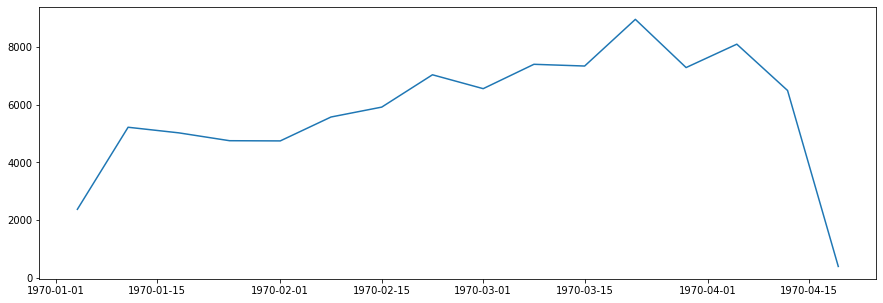

In [9]:
plt.figure(figsize=[15,5])
login_week=login.groupby(pd.Grouper(freq='W',key='login_time'))['login_time'].count().fillna(0)
sns.lineplot(data=login_week)

In [10]:
login['day_of_week']=login.login_time.apply(lambda x: x.weekday())
login['hour']=login.login_time.apply(lambda x: x.hour)

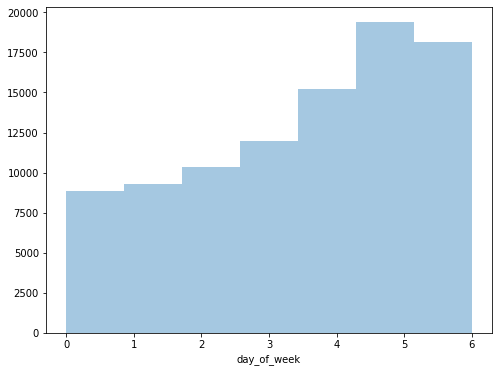

In [11]:
plt.figure(figsize=[8,6])
sns.distplot(login["day_of_week"],bins=7,kde=False)

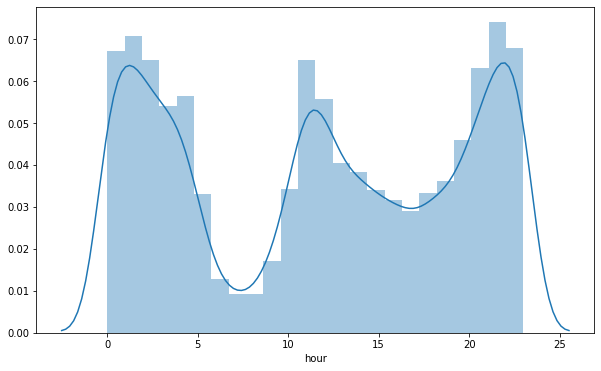

In [12]:
plt.figure(figsize=[10,6])
sns.distplot(login["hour"],bins=24)

The daily demand is high from 8pm to 4am in the morning, and 11am to 12pm. The demand is high on weekends, and gradually increases from January to March. The sharp drop in April might be caused by insufficient data collected.

### Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

In [13]:
#I'd choose the percentage of active drivers who are being active in the neighbouring city as the key measure of 
#success. There're different ways to define an active driver, for instance, a driver who works for at least 3 hours 
#during the day. Being active in the neighbouring city could mean the driver spend at least 20% of his/her time
#in the neighboring city, or he/she takes 2 or more rides in the neighbouring city.

2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success.

In [14]:
#Randomly assign 10% of drivers from city G and 10% of drivers from city M to the test group letting them know that 
#the bridge roll will be reimbursed for a period of time. To take the ramp up time into account, we start measuring the key measure of success a few days 
#after the newly implemented policy begin. Determine the practical significance level and calculate the sample size 
#needed to achive the statistical power. After the reimbursement period ends, we also want to measure if behavior of 
#drivers changes, since the reimbursement is not likely to be permanent.


### Part 3 ‑ Rider Retention Predictive modeling

In [15]:
ultimate_data=json.load((open('ultimate_data_challenge.json')))
#pd.read_json('ultimate_data_challenge.json')

In [16]:
ultimate_data=json_normalize(ultimate_data)

In [17]:
#fill NA with mean for avg_rating of driver
ultimate_data['avg_rating_of_driver'].fillna(ultimate_data['avg_rating_of_driver'].mean(),inplace=True)
#fill NA with mean for avg_rating by driver
ultimate_data['avg_rating_by_driver'].fillna(ultimate_data['avg_rating_by_driver'].mean(),inplace=True)

In [18]:
#drop records without phone information
ultimate_data=ultimate_data[ultimate_data['phone'].notna()]

In [19]:
ultimate_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
city                      49604 non-null object
trips_in_first_30_days    49604 non-null int64
signup_date               49604 non-null object
avg_rating_of_driver      49604 non-null float64
avg_surge                 49604 non-null float64
last_trip_date            49604 non-null object
phone                     49604 non-null object
surge_pct                 49604 non-null float64
ultimate_black_user       49604 non-null bool
weekday_pct               49604 non-null float64
avg_dist                  49604 non-null float64
avg_rating_by_driver      49604 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [20]:
#the data is likely to be pulled on '2014-7-1'
ultimate_data.last_trip_date.max()

'2014-07-01'

In [21]:
#convert date columns to datetime
ultimate_data.loc[:,'signup_date'] =  pd.to_datetime(ultimate_data['signup_date'], format='%Y-%m-%d')
ultimate_data.loc[:,'last_trip_date'] =  pd.to_datetime(ultimate_data['last_trip_date'], format='%Y-%m-%d')

In [22]:
#label the users into 'active' and 'inactive' cateogories
ultimate_data['active']=ultimate_data['last_trip_date']>='2014-06-01'

In [23]:
#percentage of active users
print('Percentage of active users:')
print(len(ultimate_data[ultimate_data['active']==True])/len(ultimate_data))

Percentage of active users:
0.37640109668575117


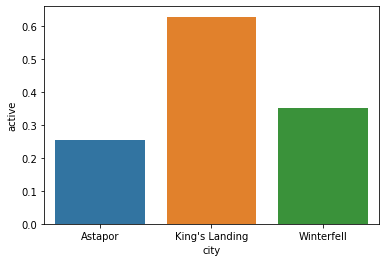

In [24]:
#King's Landing has highest percentage of active users, Astapor has lowest percentage of active users
city_active=ultimate_data.groupby(['city'])['active'].mean()
city_active=city_active.reset_index()
sns.barplot(x='city',y='active',data=city_active)

In [25]:
ultimate_data=pd.get_dummies(ultimate_data,drop_first=True)

In [26]:
ultimate_data

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,city_King's Landing,city_Winterfell,phone_iPhone
0,4,2014-01-25,4.700000,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,True,1,0,1
1,0,2014-01-29,5.000000,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,False,0,0,0
2,3,2014-01-06,4.300000,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,False,0,0,1
3,9,2014-01-10,4.600000,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,True,1,0,1
4,14,2014-01-27,4.400000,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,False,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,2014-01-25,5.000000,1.00,2014-06-05,0.0,False,100.0,5.63,4.2,True,1,0,1
49996,1,2014-01-24,4.601559,1.00,2014-01-25,0.0,False,0.0,0.00,4.0,False,0,0,1
49997,0,2014-01-31,5.000000,1.00,2014-05-22,0.0,True,100.0,3.86,5.0,False,0,1,0
49998,2,2014-01-14,3.000000,1.00,2014-01-15,0.0,False,100.0,4.58,3.5,False,0,0,1


In [27]:
#users who took more trips during the first 30 days after they signed up, are more likely to be retained active users
ultimate_data.groupby(['active'])['trips_in_first_30_days'].mean()

active
False    1.657033
True     3.304804
Name: trips_in_first_30_days, dtype: float64

(array([4.8366e+04, 1.0330e+03, 1.5800e+02, 3.2000e+01, 1.1000e+01,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0. ,  12.5,  25. ,  37.5,  50. ,  62.5,  75. ,  87.5, 100. ,
        112.5, 125. ]),
 <a list of 10 Patch objects>)

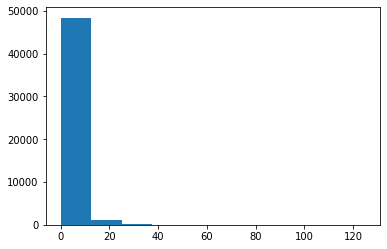

In [28]:
plt.hist(ultimate_data['trips_in_first_30_days'])

(array([4.6873e+04, 2.4440e+03, 2.4100e+02, 3.7000e+01, 8.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0.   ,  16.096,  32.192,  48.288,  64.384,  80.48 ,  96.576,
        112.672, 128.768, 144.864, 160.96 ]),
 <a list of 10 Patch objects>)

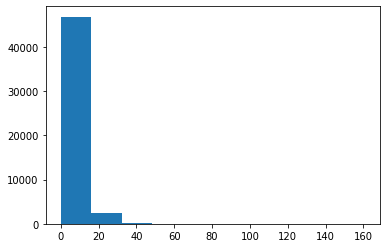

In [29]:
plt.hist(ultimate_data['avg_dist'])

In [30]:
#ultimate_black users are more likely to be retained/active users
ultimate_data.groupby(['active'])['ultimate_black_user'].value_counts()

active  ultimate_black_user
False   False                  21731
        True                    9202
True    True                    9410
        False                   9261
Name: ultimate_black_user, dtype: int64

In [31]:
ultimate_data.groupby(['active'])['avg_dist'].mean()

active
False    6.190725
True     5.113930
Name: avg_dist, dtype: float64

In [32]:
ultimate_data.groupby(['active'])['avg_rating_by_driver'].mean()

active
False    4.78699
True     4.76274
Name: avg_rating_by_driver, dtype: float64

In [33]:
ultimate_data.groupby(['active'])['avg_surge'].mean()

active
False    1.075689
True     1.073834
Name: avg_surge, dtype: float64

In [34]:
ultimate_data.groupby(['active'])['weekday_pct'].mean()

active
False    60.605952
True     61.344208
Name: weekday_pct, dtype: float64

Model Selection: 

I decide to pick a random forest to predict active users because: it usually requires very little time to optimize it (its default params are often close to the best ones) and it is strong with outliers, irrelevant variables, continuous and discrete variables. After I construct the random forest model, I use variable importance plot to get insight about the variables.

Logistic regression is also an useful algorithm to classify binary data, but it doesn't handle correlation between features very well.

In [35]:
X=ultimate_data.drop(['active','signup_date','last_trip_date'],axis=1)
y=ultimate_data['active']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=27)

In [36]:
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
y_pred_prob=clf.predict_proba(X_test)[:,1]
auc=roc_auc_score(y_test,y_pred_prob)
print(auc)

0.7595355213289251
0.8217223531373959


In [37]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

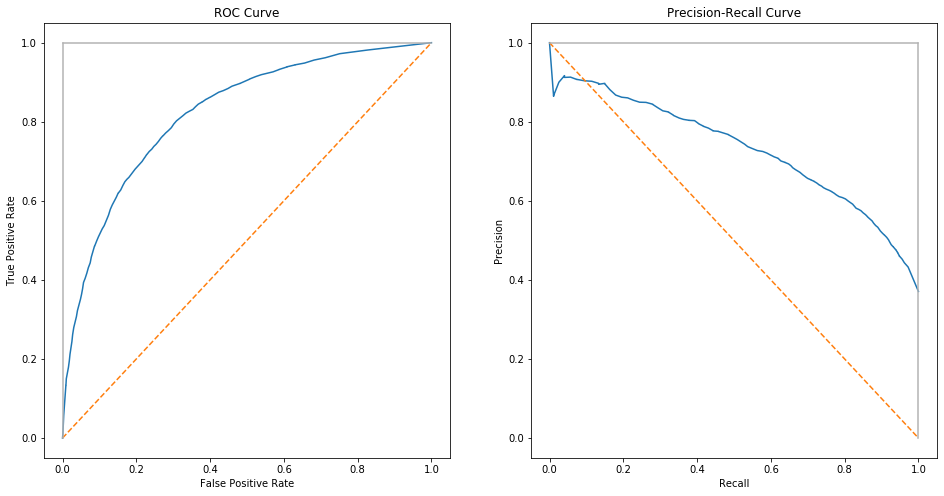

In [38]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("ROC Curve")
plt.plot(fpr,tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(1,2,2)
plt.title("Precision-Recall Curve")
plt.plot(recall,precision)
plt.plot([1, 0], ls="--")
plt.plot([1, 1], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Feature ranking:
1. feature 6 (0.305358)
2. feature 5 (0.131636)
3. feature 7 (0.121395)
4. feature 3 (0.082476)
5. feature 0 (0.080367)
6. feature 1 (0.079638)
7. feature 8 (0.064335)
8. feature 2 (0.052440)
9. feature 10 (0.037153)
10. feature 4 (0.029046)
11. feature 9 (0.016157)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

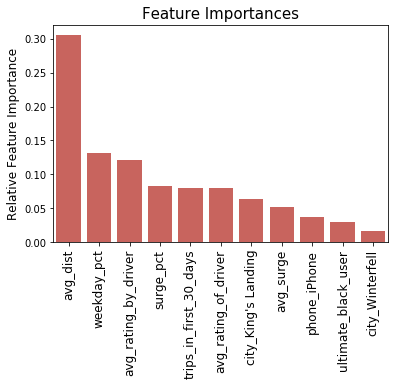

In [39]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
sns.barplot(x=X_train.columns[indices], y=importances[indices], color=sns.xkcd_rgb["pale red"])
plt.title('Feature Importances', fontsize=15)
plt.ylabel('Relative Feature Importance', fontsize=12)
plt.xticks(fontsize=12, rotation=90)

Conclusions:
    
1. Average trip distance and weekday percentage of trips are the top three predictors of active user. (shorter trip, weekday usage lead to active users) User who used Ultimate on weekdays developed a habit of using the service and more likely to be retained. The company could focus on reducing wait time at rush hours or reduce the cost of a trip during weekdays to attract more users who use the app on weekdays.


2. City of King's Landing has much higher active user rate compared to the other two cities. The company should research on the reason(e.g. publicity, competition, geography, pricing) of the cities and take measures to improve active rate in the other two cities.


3. Ultimate black users are more likely to be active users. The causal relationship is hard to identify. It could be Ultimate black users like the service and use Ultimate more, or it could be the most loyal users started to use the Ultimate black service. Marketing the Ultimate black service to the target customers could potentially lead to more active user rate.
